Fontes:

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [1]:
# Só deve descomentar 1 opção
#origemImagens = 'originais'
origemImagens = 'originaisLimpas'

In [2]:
dicionarioNomesArquivosInput = {
    'originais': ('dataset.csv', 'labels.csv'),
    'originaisLimpas': ('datasetLimpo.csv', 'labelsLimpo.csv'),
}
dicionarioNomesArquivosOutput = {
    'originais': ('datasetExpandido.csv', 'labelsExpandido.csv'),
    'originaisLimpas': ('datasetExpandidoLimpo.csv', 'labelsExpandidoLimpo.csv'),
}
(nomeArquivoDataset, nomeArquivoLabels) = dicionarioNomesArquivosInput[origemImagens]
(nomeArquivoDatasetSaida, nomeArquivoLabelsSaida) = dicionarioNomesArquivosOutput[origemImagens]

In [3]:
pathParaPastasComImagens = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/DatasetMultiprovaAvulso/'

In [4]:
juntarComDatasetAntigo = True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from datetime import datetime

In [7]:
shapeImg=(32, 32, 3)
flattenImgSize = shapeImg[0] * shapeImg[1] * shapeImg[2]

In [8]:
def countSamplesByClass(df):
  lettersCount = Counter(df)
  plt.figure(figsize=(10,10))
  plt.barh(list(lettersCount.keys()), list(lettersCount.values()))
  plt.title('Quantidade de amostras por letras')
  plt.xlabel('Quantidade de amostras')
  plt.ylabel('Letras')
  plt.show()

In [9]:
datagen = ImageDataGenerator(zoom_range=[1, 1.5], rotation_range=15, width_shift_range=4, height_shift_range=4)

In [10]:
# Se reajustar a célula que cria o datagen deve rodar essa novamente
def createNewImagesWithZoom(singleRowBaseImg, numberOfVariants, showResults = False):
  baseImg = np.array(singleRowBaseImg).reshape(shapeImg[0], shapeImg[1], shapeImg[2])
  samples = np.expand_dims(baseImg, 0)
  it = datagen.flow(samples, batch_size=1)
  output = []
  for _ in range(numberOfVariants):
    batch = it.next()
    newImg = batch[0].astype('float32')
    newImg = np.array(newImg).reshape(flattenImgSize)
    output.append(newImg)
    if showResults:
      imgToShow = np.array(newImg).reshape(shapeImg[0], shapeImg[1], shapeImg[2])
      plt.imshow(imgToShow, cmap="gray")
      plt.show()
  return output

In [11]:
tipoImagem = '10'
pathToFolder = pathParaPastasComImagens + tipoImagem + '/'
pathToDataset = pathToFolder + nomeArquivoDataset
pathToLabel = pathToFolder + nomeArquivoLabels
dataset = pd.read_csv(pathToDataset).astype('float32')
labels = pd.read_csv(pathToLabel, squeeze=True).astype('string')

In [12]:
print('Quantidade de amostras antes do aumento:', len(labels))

Quantidade de amostras antes do aumento: 1176


In [14]:
quantidadeDeNovasImagens = 5000
copiasPorImagem = 5

In [15]:
dfKeys = dataset.keys()
def addImageToDataframe(df, singleRowImg, newIdx):
  newImageByKeys = {}
  enumDfKeys = enumerate(dfKeys)
  for (idx, key) in enumDfKeys:
    newImageByKeys[key] = singleRowImg[idx]
  df.loc[newIdx] = newImageByKeys

Imagem original:


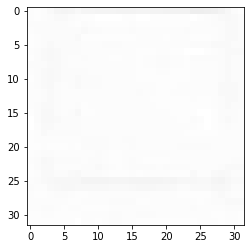

Imagens geradas a partir da original:


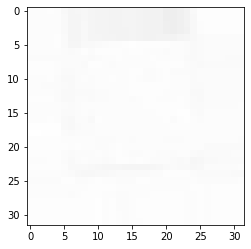

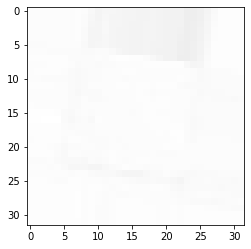

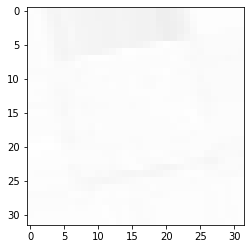

In [16]:
indexImg = 1159
testImg = dataset.iloc[indexImg]
testImg = np.array(testImg).reshape(shapeImg[0], shapeImg[1], shapeImg[2])
plt.imshow(testImg, cmap="gray")
print('Imagem original:')
plt.show()
print('Imagens geradas a partir da original:')
testImg2 = dataset.iloc[indexImg]
testImg2 = np.array(testImg2).reshape(flattenImgSize)
results = createNewImagesWithZoom(testImg2, 3, True)

In [17]:
copiesDf = pd.DataFrame(data=None, columns=dataset.columns, index=[], dtype='float32')

In [18]:
actualLen = 0
maxToSearch = len(labels)
numCopiesStep = copiasPorImagem
maxCopies = quantidadeDeNovasImagens

actualCopies = 0
progressControl = 0
stepOfPrints = 500
currClass = tipoImagem

print("start =", datetime.now().time())
for idxImg in range(0, maxToSearch):
  img = dataset.iloc[idxImg]
  newImgs = createNewImagesWithZoom(img, numCopiesStep)
  for newImg in newImgs:
    addImageToDataframe(copiesDf, newImg, actualLen)
    actualLen += 1
  actualCopies += numCopiesStep
  progressControl += numCopiesStep
  if progressControl >= stepOfPrints: 
    progressControl = 0
    print(actualCopies, "in", datetime.now().time())
  if actualCopies >= maxCopies:
    break
print("end =", datetime.now().time())

start = 13:47:46.477222
500 in 13:50:29.858596
1000 in 13:53:12.192847
1500 in 13:55:54.812765
2000 in 13:58:37.225050
2500 in 14:01:21.167790
3000 in 14:04:12.827508
3500 in 14:07:03.562915
4000 in 14:09:53.602939
4500 in 14:12:45.182392
5000 in 14:15:38.900550
end = 14:15:38.900938


In [19]:
copiesLabelsTest = pd.DataFrame([tipoImagem] * len(copiesDf))

In [20]:
print(len(copiesDf))
print(len(copiesLabelsTest))

5000
5000


In [21]:
# Só deve ser rodado se NÃO deseja juntar o dataset antigo com as novas imagens
if not juntarComDatasetAntigo:
  finalDf = copiesDf
  finalLabelsDf = copiesLabelsTest

In [22]:
# Só deve ser rodado se deseja juntar o dataset antigo com as novas imagens
if juntarComDatasetAntigo:
  finalDf = pd.concat([copiesDf, dataset])
  finalLabelsDf = pd.concat([copiesLabelsTest, labels])

In [23]:
print(len(finalDf))
print(len(finalLabelsDf))

6176
6176


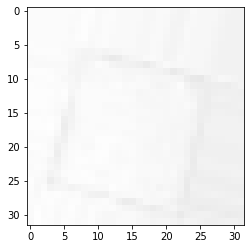

In [24]:
indexImg = 3773
testImg = finalDf.iloc[indexImg]
testImg = np.array(testImg).reshape(shapeImg[0], shapeImg[1], shapeImg[2])
plt.imshow(testImg, cmap="gray")
plt.show()

In [25]:
pathToExportDF = pathToFolder + nomeArquivoDatasetSaida
pathToExportLabels = pathToFolder + nomeArquivoLabelsSaida

In [26]:
finalDf.to_csv(path_or_buf=pathToExportDF, index=False)
finalLabelsDf.to_csv(path_or_buf=pathToExportLabels, index=False)